# Transfer learning classifier for zebrafish classification

This notebook is used for training of transfer learning, MobileNetV2-based classifier of zebrafish embryo mutants. The training and evaluation of the classifier is followed by Class activation mapping (CAM) analysis which points to the predictive feature of the zebrafish embryo images.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from skimage.transform import resize
import pandas as pd
import numpy as np
import tifffile
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice
from sklearn import metrics
from pathlib import Path
import seaborn as sns
sns.set_style('white')
from utils import create_dataset
# set manual seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

### Getting the zebrafish data

Download and unzip the training data (images and classes) into the subfolder `data`
```
wget https://zenodo.org/record/6651752/files/data.zip?download=1  -O data.zip
unzip data.zip
```

Which should result in the following 

```
data
├── fish_part_labels
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
├── training
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
└── validation
    ├── DAPT
    ├── her1;her7
    ├── tbx6_fss
    └── WT
```

In [2]:
dataroot= Path('data')
target_size = (450,900)

epochs  = 50
n_tiles = 1 # splits images in n_tiles along every axis (to asses how much context matters)

### Loading the zebrafish data

Found 398 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
{'DAPT': 0, 'WT': 1, 'her1;her7': 2, 'tbx6_fss': 3}
{0: 'DAPT', 1: 'WT', 2: 'her1;her7', 3: 'tbx6_fss'}


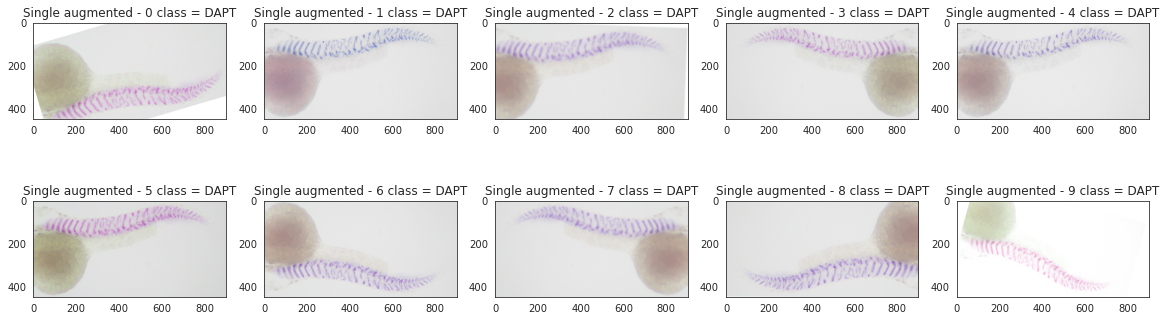

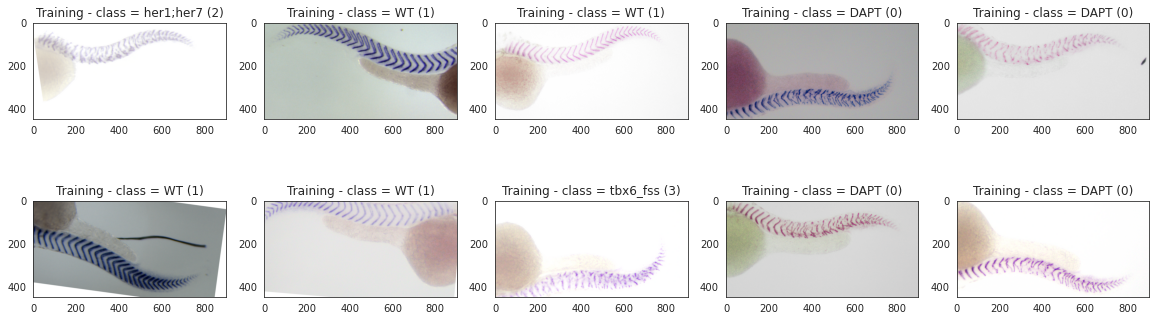

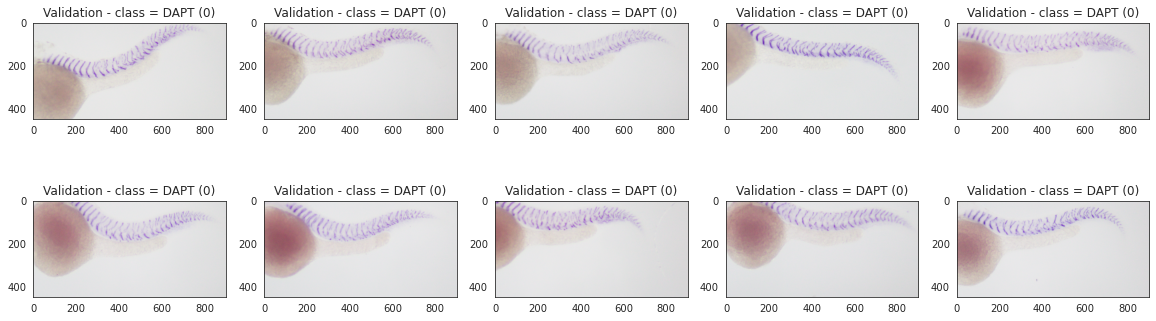

In [3]:
data_train = create_dataset(dataroot/"training",   target_size=target_size, batchsize=16, shuffle=True,  augment=True, n_tiles=n_tiles)
data_val   = create_dataset(dataroot/"validation", target_size=target_size, batchsize=16, shuffle=False, augment=False, n_tiles=n_tiles)

print(data_train.class_name_to_id)
print(data_train.class_id_to_name)

# plot some example training and validation images
n=5

plt.figure(figsize=(20,6))
for i in range(2*n):
    _x = data_train.transform(image=data_train.images[0])['image']
    plt.subplot(2, n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Single augmented - {i} class = {data_train.class_id_to_name[data_train.labels[0]]}')
     
x,y = next(iter(data_train.data))
plt.figure(figsize=(20,6))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Training - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')

x,y = next(iter(data_val.data))
plt.figure(figsize=(20,6))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Validation - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')


### Building and compiling transfer learning classifier

In [4]:
inp = tf.keras.Input(shape=tuple(s//n_tiles for s in target_size)+(3,))
model_pretrained = tf.keras.applications.MobileNetV2(input_shape = tuple(s//n_tiles for s in target_size)+(3,), 
                                       include_top=False, weights='imagenet')
model_pretrained.trainable = False #freeze the weights
out = model_pretrained(inp, training=False)
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = tf.keras.layers.Dense(4)(out)
model = tf.keras.Model(inp, out)

learning_rate = 0.0005

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['sparse_categorical_accuracy'])

#preparing the weights for balanced training
counts_mean = np.mean(tuple(data_train.counts.values()))
class_weights = dict((k, counts_mean/v) for k,v in data_train.counts.items())
print(f'class weights: {class_weights}')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00025, verbose = 1)

checkpoint_folder = Path('checkpoints')
checkpoint_folder.mkdir(exist_ok=True, parents=True)

checkpoint_filepath = checkpoint_folder/f"transfer_learning_classifier_n_{n_tiles}.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)

class weights: {0: 0.7834645669291339, 1: 0.5653409090909091, 2: 1.7155172413793103, 3: 2.689189189189189}


### Training the classifier

In [5]:
history = model.fit(data_train.data.repeat(4),
                epochs=epochs,
                validation_data=data_val.data,
                class_weight=class_weights, callbacks=[model_checkpoint_callback])
np.save(checkpoint_folder/f"transfer-learning_lr_{learning_rate:.4f}_epochs_{epochs}.npy",history.history)

Epoch 1/50
100/100 [==============================] - 16s 75ms/step - loss: 1.2916 - sparse_categorical_accuracy: 0.4215 - val_loss: 1.0085 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/50
100/100 [==============================] - 11s 97ms/step - loss: 0.9668 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.7679 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/50
100/100 [==============================] - 11s 98ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.7996 - val_loss: 0.6280 - val_sparse_categorical_accuracy: 0.8250
Epoch 4/50
100/100 [==============================] - 11s 97ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.8423 - val_loss: 0.5423 - val_sparse_categorical_accuracy: 0.8625
Epoch 5/50
100/100 [==============================] - 11s 92ms/step - loss: 0.5691 - sparse_categorical_accuracy: 0.8750 - val_loss: 0.4490 - val_sparse_categorical_accuracy: 0.9500
Epoch 6/50
100/100 [==============================] - 11s 98ms/step - loss: 0.4928 - spars

Epoch 46/50
100/100 [==============================] - 10s 88ms/step - loss: 0.1783 - sparse_categorical_accuracy: 0.9598 - val_loss: 0.1051 - val_sparse_categorical_accuracy: 0.9875
Epoch 47/50
100/100 [==============================] - 11s 93ms/step - loss: 0.1596 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1010 - val_sparse_categorical_accuracy: 0.9750
Epoch 48/50
100/100 [==============================] - 11s 92ms/step - loss: 0.1578 - sparse_categorical_accuracy: 0.9648 - val_loss: 0.0987 - val_sparse_categorical_accuracy: 0.9875
Epoch 49/50
100/100 [==============================] - 10s 90ms/step - loss: 0.1537 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.1067 - val_sparse_categorical_accuracy: 0.9625
Epoch 50/50
100/100 [==============================] - 11s 94ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9750


### Plotting the learning curves

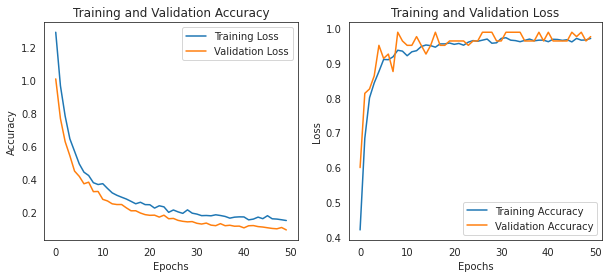

In [6]:
acc = history.history[f'sparse_categorical_accuracy']
val_acc = history.history[f'val_sparse_categorical_accuracy']

loss = history.history[f'loss']
val_loss = history.history[f'val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss');


### Loading weights from the best epoch

In [7]:
model.load_weights(checkpoint_filepath)

### Calculate confusion matrix

5/5 [==============================] - 1s 59ms/step


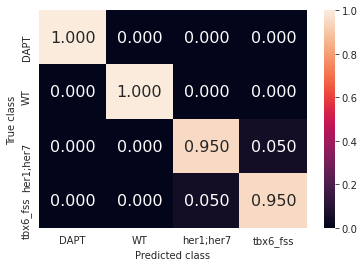

Accuracy: 0.9750


In [8]:
y_true = np.array(data_val.labels)
y_pred = np.argmax(model.predict(data_val.data), -1)

def calculate_confusion_matrix(y_true, y_pred):
    classes = tuple(data_val.class_id_to_name[i] for i in range(4))
    matrix = metrics.confusion_matrix(y_true, y_pred) #rows - true, columns - predicted
    matrix = matrix/np.sum(matrix, axis=-1, keepdims=True)
    
    df_cm = pd.DataFrame(matrix, index=classes, columns=classes)
    # plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='1.3f')# font size
    plt.ylabel("True class")
    plt.xlabel("Predicted class") 
    plt.show()
    accuracy = np.sum(np.diag(matrix))/np.sum(matrix)
    print(f'Accuracy: {accuracy:.4f}') 
    return accuracy

accuracy = calculate_confusion_matrix(y_true, y_pred)

# Apply the model to new images from a different microscope (`kings` subset)

Put the `kings` images (in bmp format) in the subfolder `data/kings`, resulting in 

```
data
├── fish_part_labels
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
├── kings
│   ├── DAPT
│   └── WT
├── training
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
└── validation
    ├── DAPT
    ├── her1;her7
    ├── tbx6_fss
    └── WT
```

Found 51 files belonging to 2 classes.


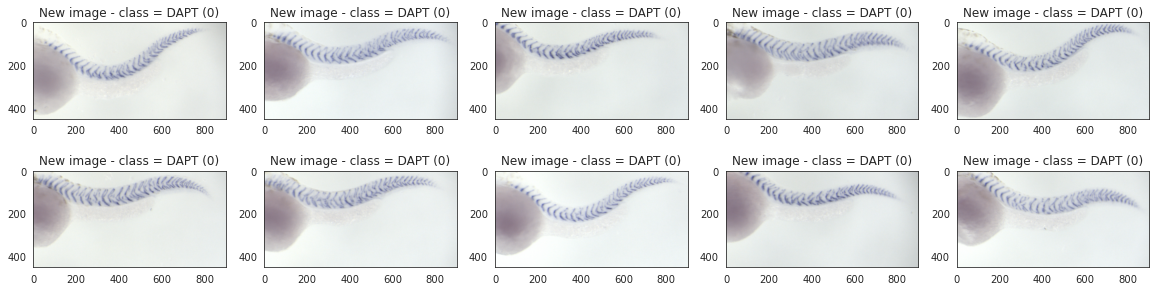

In [9]:
data_new = create_dataset(dataroot/'kings', augment=False, shuffle=False, target_size=target_size)

x,y = next(iter(data_new.data))
plt.figure(figsize=(20,5))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'New image - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')


In [10]:
y_true = np.array(tuple(data_new.class_id_to_name[c] for c in data_new.labels))
y_prob = tf.math.softmax(model.predict(data_new.data))
y_pred = np.array(tuple(data_train.class_id_to_name[c] for c in np.argmax(y_prob, -1)))
y_prob = np.max(y_prob, axis=-1)

accuracy = np.mean(y_true==y_pred)
print(f'Accuracy: {accuracy:.5f}')


4/4 [==============================] - 1s 128ms/step
Accuracy: 0.82353


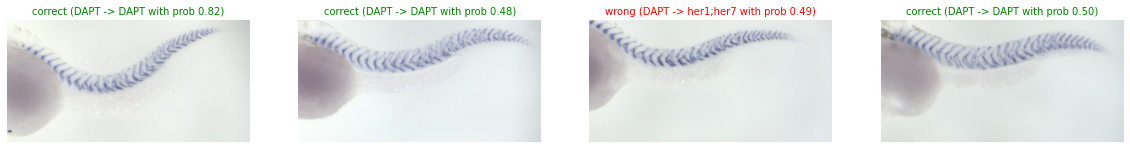

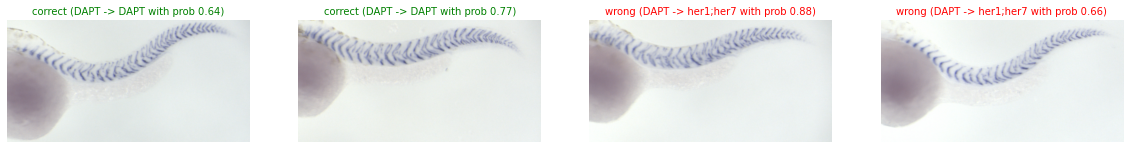

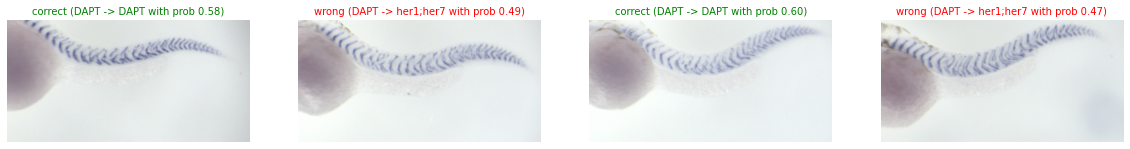

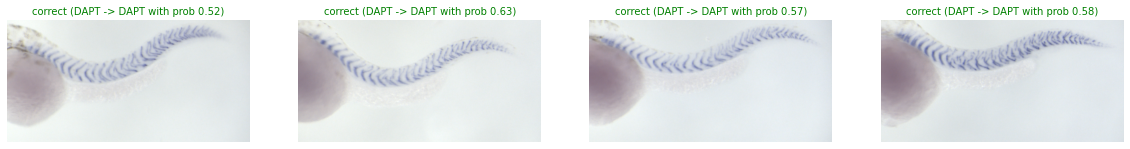

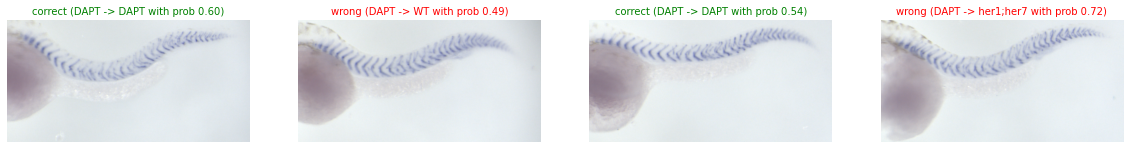

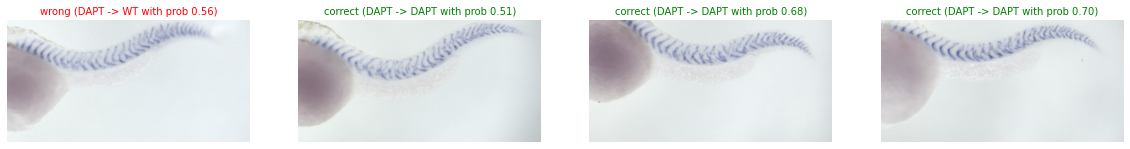

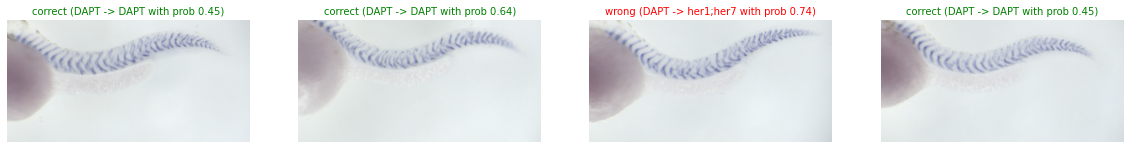

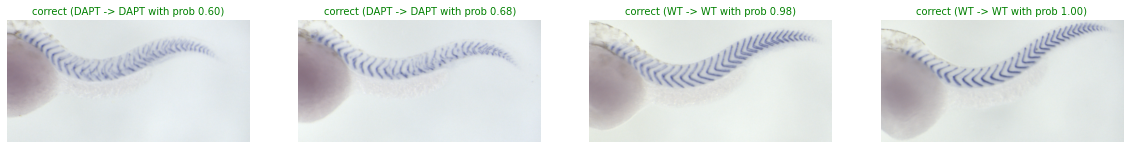

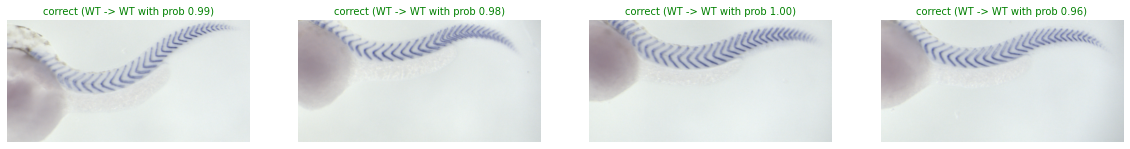

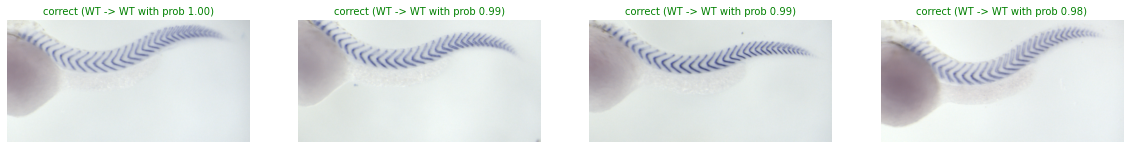

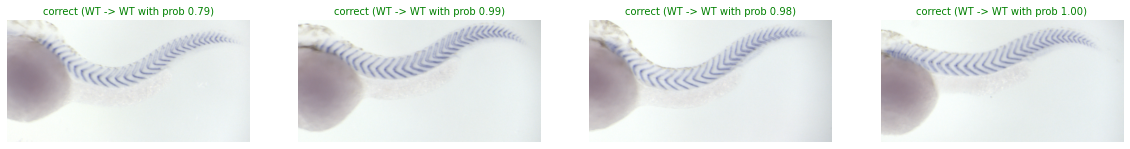

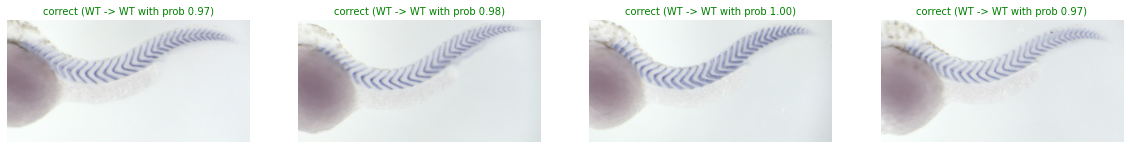

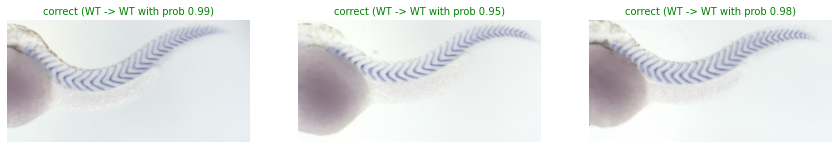

In [11]:
for i, (x, fname, y1, y2, prob) in enumerate(zip(data_new.images, data_new.filenames, y_true, y_pred, y_prob)):
    if i%4==0:
        plt.figure(figsize=(20,4))
    ax = plt.subplot(1,4,i%4+1)
    ax.imshow(x)
    correct = y1==y2
    ax.set_title(f'{"correct" if correct else "wrong"} ({y1} -> {y2} with prob {prob:.2f})', fontsize=10)
    ax.title.set_color('green' if correct else 'red')
    ax.axis('off')

### CAM analysis

Found 80 files belonging to 4 classes.


  0%|          | 0/80 [00:00<?, ?it/s]

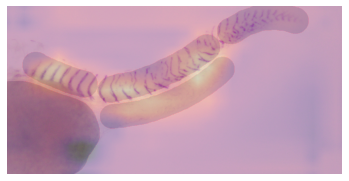

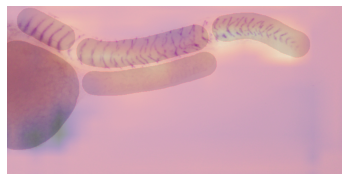

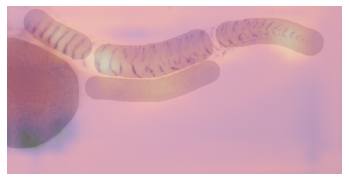

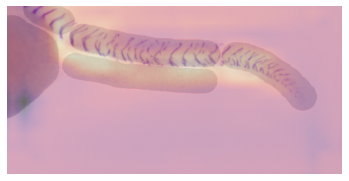

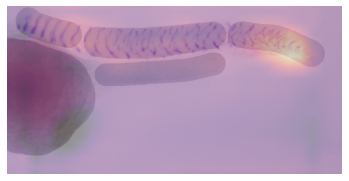

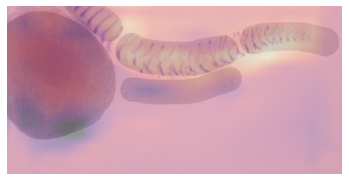

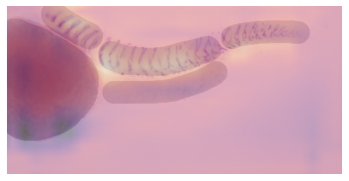

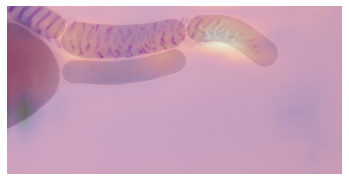

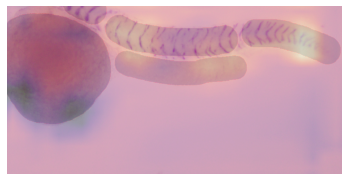

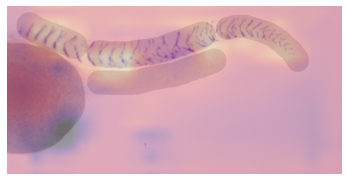

In [15]:
#adapted from: https://nbviewer.jupyter.org/github/vincent1bt/Machine-learning-tutorials-notebooks/blob/master/activationMaps/ActivationsMaps.ipynb
#deeper explanation here: https://vincentblog.xyz/posts/class-activation-maps
def get_activation_map(image, image_class): 
        #we assume image is given in a shape of [0, a, b, 3] - axb RGB image in a tupple of 1 file - this is needed so that it's compatible with predict
        #image_class is the true class

        inp = tf.keras.Input(shape=target_size+(3,))
        class_weights = model.layers[-1].get_weights()[0]
        get_output = tf.keras.backend.function([inp], 
                                      [model_pretrained(inp)])
        
        predictions = model.predict(image, verbose=False)
        [conv_outputs] = get_output(image)
        conv_outputs = conv_outputs[0, :, :, :]

        cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

        for index, weight in enumerate(class_weights[:, image_class]):
            cam += weight * conv_outputs[:, :, index]
        
        class_predicted = np.argmax(predictions[0])
        predictions = f'Class predicted: {class_predicted} | Real class: {image_class}'
        
        cam /= np.max(cam)
        cam = resize(cam, (image.shape[1], image.shape[2]))
        #puting cam into 0-1 range
        scaled_cam = cam + np.abs(np.min(cam))
        scaled_cam = scaled_cam/np.sum(scaled_cam) 
        return scaled_cam

data_test = create_dataset(dataroot/"validation", target_size=target_size, batchsize=1, shuffle=False, augment=False, n_tiles=n_tiles)

#saving of the predicted images
cam_folders = dict((k, Path('CAM_results')/v) for k,v in data_test.class_id_to_name.items())
for k,folder in cam_folders.items():
    folder.mkdir(exist_ok =True, parents=True)
        
#folder with parts of the fish
folder_parts = dataroot/"fish_part_labels"

for i, ((x,y),filename) in tqdm(enumerate(zip(data_test.data, data_test.filenames)), total=len(data_test.data)):
    y_pred = np.argmax(model.predict(x,verbose=False), axis=-1)
    y_true = int(y[0])
    cam = get_activation_map(x, y_true)   
    
    fname_parts = Path(*Path(filename).parts[-2:])
    parts = tifffile.imread(folder_parts/f'{fname_parts}.tiff')
    resized_parts = resize(parts, (450,900), order=0) #everything is streched to the shape of the loaded image
    parts_array_binarized = np.where(resized_parts > 0, 0, 1)

    if i<10:
        fig = plt.figure()
        plt.imshow(x[0])   
        plt.imshow(resize(cam,x[0].shape[:2]), alpha=0.4, cmap = 'magma')
        plt.imshow(parts_array_binarized, alpha = 0.1)
        plt.box(False)
        plt.axis('off')
        
    plt.savefig(cam_folders[y_true]/Path(filename).name, dpi = fig.dpi, transparent=True)


### Calculating the per-class- and per-fish-part CAM attention for images from the validation set

In [13]:
def calculate_attention(image, mask, index, normalization = False):
    if(image.shape != mask.shape):
        raise Exception('Image and Mask should have the same shape', image.shape, mask.shape)

    index_mask = (mask==index)
    attention = np.sum(index_mask*image)
    if normalization:
        attention = attention / (np.sum(index_mask)+1e-10)
    return attention

Attention = np.empty((4, 6, 20)) #4 rows are the classes, 5 colums are different zebrafish parts
#indices for zebrafish parts: (in the array as well the values on the zebrafish part paintings)
#0 - background
#1 - head
#2 - trunk
#3 - tail 
#4 - yolk
#5 - yolk extension

class_counter = np.zeros(4) #keeping track of how many images from a certain class there were so far
normalization = 1


for i, ((x,y),filename) in tqdm(enumerate(zip(data_test.data, data_test.filenames)), total=len(data_test.data)):
    y_pred = np.argmax(model.predict(x,verbose=False), axis=-1)
    y_true = int(y[0])
    cam = get_activation_map(x, y_true)   
    resized_cam = resize(cam, x[0].shape[:2])
    #resizing changes values so we scale attention back to 1
    resized_cam = resized_cam/np.sum(resized_cam)
    
    fname_parts = Path(*Path(filename).parts[-2:])
    parts = tifffile.imread(folder_parts/f'{fname_parts}.tiff')
    resized_parts = resize(parts, (450,900), order=0) #everything is streched to the shape of the loaded image

    for p in range(0,6):
        Attention[int(y_true), p, int(class_counter[int(y_true)])] = calculate_attention(resized_cam, resized_parts, p, normalization)                
    class_counter[int(y_true)] = class_counter[int(y_true)] + 1

  0%|          | 0/80 [00:00<?, ?it/s]

### Plotting CAM results

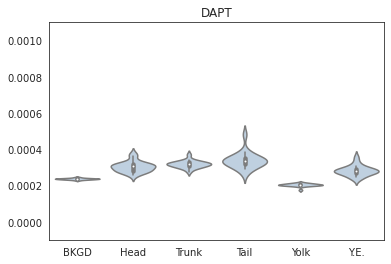

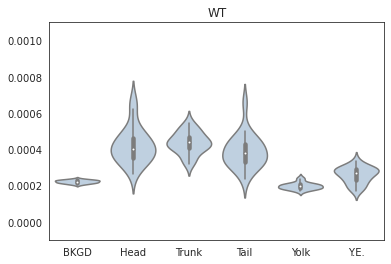

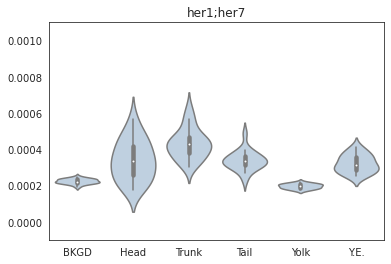

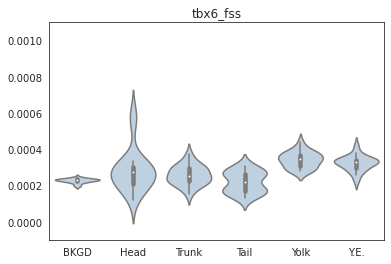

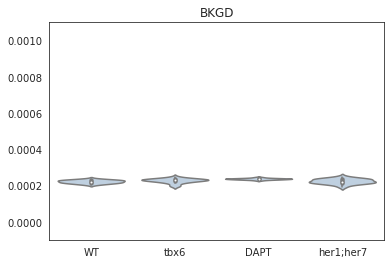

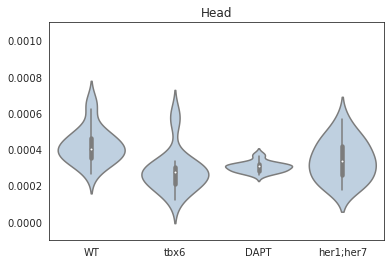

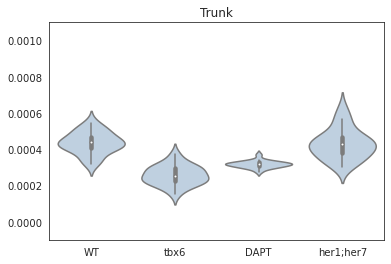

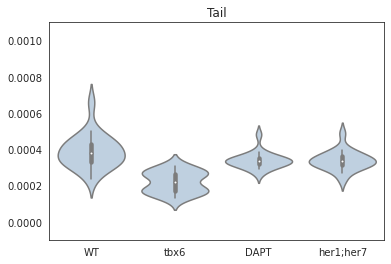

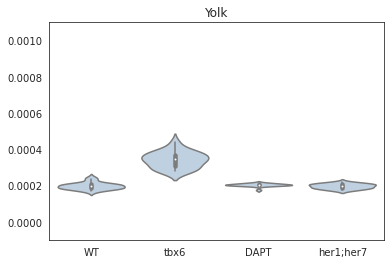

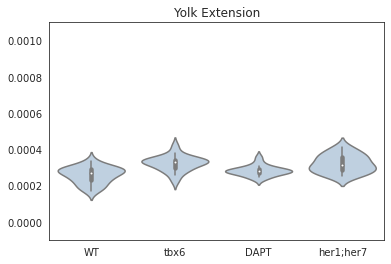

In [14]:
#plotting per class
for i in range(4):
    df = pd.DataFrame({'BKGD': Attention[i, 0, :], 'Head': Attention[i, 1, :], 'Trunk': Attention[i, 2, :], 'Tail': Attention[i, 3, :], 'Yolk': Attention[i, 4, :], 'Y.E.': Attention[i, 5, :]})
    
    plt.figure()
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.title(data_val.class_id_to_name[i])
    plt.ylim([-0.0001, 0.0011])

parts = ['BKGD', 'Head', 'Trunk', 'Tail', 'Yolk', 'Yolk Extension']

#plotting per fish part
for i in range(6):
    df = pd.DataFrame({'WT': Attention[1, i, :], 'tbx6': Attention[3, i, :], 'DAPT': Attention[0, i, :], 'her1;her7': Attention[2, i, :]})
    plt.figure()
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.title(parts[i])
    plt.ylim([-0.0001, 0.0011])